# YOLO on TensorFlow

This notebook aims to create a trainable and usable version of YOLO on TensorFlow.

In [1]:
# *** IMPORT ***
import tensorflow as tf
from tf_yolo_utils import *   # fcts. to create custom layers

# Import kitti_utils from a different project
import sys
sys.path.insert(0, '/data2/lucas/Projects/Kitti2012')
from kitti_utils import *    # fcts. to manage the kitti dataset

In [2]:
print_labels(import_labels(700, 'train'))

----------------------------------------------------------------------
|type            |  y_min     |  x_min     |  x_max     |  y_max     |
----------------------------------------------------------------------
----------------------------------------------------------------------
|Car             |  176.1     |  581.85    |  600.06    |  190.53    |
----------------------------------------------------------------------
|Car             |  183.14    |  292.06    |  399.96    |  243.71    |
----------------------------------------------------------------------
|DontCare        |  166.69    |  559.56    |  576.27    |  188.61    |
----------------------------------------------------------------------
|DontCare        |  162.52    |  574.15    |  603.36    |  177.15    |
----------------------------------------------------------------------
|DontCare        |  161.48    |  609.56    |  624.18    |  175.06    |
----------------------------------------------------------------------


## The YOLO Architecture
![The YOLO Architecture](doc_img/YOLO_architecture.png)

The YOLO Detection network has 24 convolutional layers followed by 2 fully connected layers.

The predictions are encoded as an S x S x (B * 5 + C) tensor where S x S is the size of the grid that divides the input images. B is the number of boxes in one cell grid, C the number of conditional class probabilites.

N.B. __IoU (Intersection over Union)__ is an evaluation metric used to measure the accuracy of an object detector on a particular dataset.

![Intersection over Union Illustration](doc_img/iou_equation+examples.png)
_Source:[pyimagesearch.com](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)_ 

In [3]:
# --- HYPERPARAMETERS ---
TRAIN_PERC = 60   # Percentage of the data to put in the training set
DEV_PERC = 20     # Percentage of the data to put in the dev set
TEST_PERC = 20    # Percentage of the data to put in the test set

SEED = 42         # Seed used to randomize the dataset

BATCH_SIZE = 50   # Size of a batch of data
STEPS = 5000      # Number of step to train the CNN

IM_SIZE = 448     # 448=7*64  (Original shape of the image=(375, 1242, 3))
S = 7             # S x S grid the image is divided into
B = 2             # B = number of boxes per cell grid

# List of all the possible classes
LIST_CLASSES = ['Car', 'Van', 'Truck',
                'Pedestrian', 'Person_sitting', 
                'Cyclist', 'Tram', 'Misc', 
                'DontCare']

C = len(LIST_CLASSES)  # C = number of labelled classes

# --- IMPORT DATA ---
ids_for_training = get_data_list('train')
train_batches_ids, dev_batches_ids, test_batches_ids = prepare_dataset(ids_for_training, [TRAIN_PERC, DEV_PERC, TEST_PERC], BATCH_SIZE, SEED)

# --- IMPORT BATCH ---
# Function to import the images in the batches and to format the labels
# - TODO -

# --- DEFINE CNN ---
x = tf.placeholder(tf.float32, shape=[None, IM_SIZE, IM_SIZE, 3])
y = tf.placeholder(tf.float32, shape=[None, S * S * (B * 5 + C)])

# --- CONV. LAYER 1 ---
# 7x7x64-s-2
# Maxpool: 2x2-s-2

conv1 = conv_layer(x, shape=[7, 7, 3, 64], strides=[1,2,2,1])
conv1_pool = max_pool_2x2(conv1)

# --- CONV. LAYER 2 ---
# 3x3x192
# Maxpool: 2x2-s-2

conv2 = conv_layer(conv1_pool, shape=[3, 3, 64, 192], strides=[1,2,2,1])
conv2_pool = max_pool_2x2(conv2)

# --- CONV. LAYERS 3 ---
# 1x1x128
# 3x3x256
# 1x1x256
# 3x3x512
# Maxpool: 2x2-s-2

conv3_1 = conv_layer(conv2_pool, shape=[1, 1, 192, 128])
conv3_2 = conv_layer(conv3_1, shape=[3, 3, 128, 256])
conv3_3 = conv_layer(conv3_2, shape=[1, 1, 256, 256])
conv3_4 = conv_layer(conv3_3, shape=[3, 3, 256, 512])
conv3_pool = max_pool_2x2(conv3_4)

# --- CONV. LAYERS 4 ---
# 1x1x256  ____ x4
# 3x3x512  _|
# 1x1x512
# 3x3x1024
# Maxpool: 2x2-s-2

conv4_1 = conv_layer(conv3_pool, shape=[1, 1, 512, 256])
conv4_2 = conv_layer(conv4_1, shape=[3, 3, 256, 512])

conv4_3 = conv_layer(conv4_2, shape=[1, 1, 512, 256])
conv4_4 = conv_layer(conv4_3, shape=[3, 3, 256, 512])

conv4_5 = conv_layer(conv4_4, shape=[1, 1, 512, 256])
conv4_6 = conv_layer(conv4_5, shape=[3, 3, 256, 512])

conv4_7 = conv_layer(conv4_6, shape=[1, 1, 512, 256])
conv4_8 = conv_layer(conv4_7, shape=[3, 3, 256, 512])

conv4_9 = conv_layer(conv4_8, shape=[1, 1, 512, 512])
conv4_10 = conv_layer(conv4_9, shape=[3, 3, 512, 1024])

conv4_pool = max_pool_2x2(conv4_10)

# --- CONV. LAYERS 5 ---
# 1x1x512   ____ x2
# 3x3x1024  _|
# 3x3x1024
# 3x3x1024-s-2

conv5_1 = conv_layer(conv4_pool, shape=[1, 1, 1024, 512])
conv5_2 = conv_layer(conv5_1, shape=[3, 3, 512, 1024])

conv5_3 = conv_layer(conv5_2, shape=[1, 1, 1024, 512])
conv5_4 = conv_layer(conv5_3, shape=[3, 3, 512, 1024])

conv5_5 = conv_layer(conv5_4, shape=[3, 3, 1024, 1024])

conv5_6 = conv_layer(conv5_5, shape=[3, 3, 1024, 1024], strides=[1, 2, 2, 1])

# --- CONV. LAYERS 6 ---
# 3x3x1024
# 3x3x1024

conv6_1 = conv_layer(conv5_6, shape=[3, 3, 1024, 1024])
conv6_2 = conv_layer(conv6_1, shape=[3, 3, 1024, 1024])

# --- FULL LAYER 1 ---
# 4096

conv6_2_flatten = tf.reshape(conv6_2, [-1, 16 * 1024]) # Got it to 16*1024 to have only one l ouput per image

full_1_ = full_layer(conv6_2_flatten, 4096)
full_1 = tf.maximum(full_1_, 0.1 * full_1_)  # Leaky ReLU

full_1_drop = tf.nn.dropout(full_1, keep_prob=0.5)

# --- FULL LAYER 2 ---

full_2 = full_layer(full_1_drop, S * S * (B * 5 + C))


In [4]:
# try to get an image run through the CNN
# import image
im_1_ = import_im(111, 'train')
im_1_ = misc.imresize(im_1_, (IM_SIZE, IM_SIZE, 3))
im_1 = im_1_.reshape([-1, IM_SIZE, IM_SIZE, 3])

im_2_ = import_im(222, 'train')
im_2_ = misc.imresize(im_2_, (IM_SIZE, IM_SIZE, 3))
im_2 = im_2_.reshape([-1, IM_SIZE, IM_SIZE, 3])

ims = np.concatenate((im_1, im_2),axis=0)

print(ims.shape)

# initialize variables
sess = tf.Session()

sess.run(tf.global_variables_initializer())

result = sess.run(full_2, feed_dict = {x: ims})

result.shape

(2, 448, 448, 3)


(2, 931)

In [29]:
def convert_labels_to_array(labels, S, B, im_shape, list_classes = LIST_CLASSES):
    """
    Convert the dictionary to an array similar to the output of the YOLO CNN
    
    Argument:
    labels        -- Dictionary containing information about boxes
    S             -- Number of cell grid per dimension
    B             -- Number of boxes per cell grid
    im_shape      -- [image_height, image_width]
    list_classes  -- List of all the classes possible (use to create the one-hot vector)
    
    Returns:
    Return array of length (S * S * (B * 5 + C)) containing the labels
    """
    # Get cells shape from the image shape
    cell_width = im_shape[1] / S
    cell_height = im_shape[0] / S
    
    # Create the empty numpy array to contain all the labels
    arr_labels = np.zeros(S * S * (B * 5 + len(list_classes)))
    
    for label in labels:
        # --- EXPORT DATA ---

        # Extract from Paper:
        # "Each bounding box consists of 5 predictions: x, y, w, h,
        # and confidence. The (x, y) coordinates represent the center
        # of the box relative to the bounds of the grid cell. The width
        # and height are predicted relative to the whole image."

        # *** POSITION DATA ***

        # Width and Height of the box in pixel size
        box_width = label['bbox']['x_max'] - label['bbox']['x_min']  
        box_height = label['bbox']['y_max'] - label['bbox']['y_min']

        # Normalize the width and height of the box
        box_width_norm = box_width / im_shape[1]
        box_height_norm = box_height / im_shape[0]

        # Center of the box in pixel coordinates
        x_center = (label['bbox']['x_min'] + (box_width/2))
        y_center = (label['bbox']['y_min'] + (box_height/2))

        # Coordinates of the cell the center of the object is in (from 0 to ...)
        x_cell = math.floor(x_center / im_shape[1] * S)
        y_cell = math.floor(y_center / im_shape[0] * S)

        # Coordinates of the center of the box relative to the box
        box_center_x_norm = (x_center - x_cell * cell_width) / cell_width
        box_center_y_norm = (y_center - y_cell * cell_height) / cell_height

        box_IoU = 1   # As it is the ground truth

        box_info = [box_center_x_norm, box_center_y_norm,
                    box_width_norm, box_height_norm, box_IoU]

        # *** CLASS DATA ***

        class_proba = np.zeros(len(list_classes))

        index_class = list_classes.index(label['type'])

        class_proba[index_class] = 1

        # --- ADD DATA ---
        # Add the label to the array of labels

        # Extract the grid cell data and the different info
        idx_start = y_cell * S * (B * 5 + C) + x_cell * (B * 5 + C)
        idx_end = idx_start + (B * 5 + C)
        cell_data = arr_labels[idx_start : idx_end]

        # Extract objects and class probabilities
        box_info_1 = cell_data[: 5]
        box_info_2 = cell_data[5 : 10]
        cell_class_proba = cell_data[10 :]

        # If the cell is empty
        if not np.sum(cell_class_proba):
            # Add the box in the first position
            box_info_1 = box_info
            # Add the class probabilities
            cell_class_proba = class_proba

        else:
            # Compute area of the boxes
            box_area =  np.prod(box_info[2:4])
            box_area_1 = np.prod(box_info_1[2:4])
            box_area_2 = np.prod(box_info_2[2:4])

            # Compare the areas
            box_bigger_than_box_1 = box_area > box_area_1
            box_bigger_than_box_2 = box_area > box_area_2

            # Compare the classes
            same_class = np.array_equal(class_proba, cell_class_proba)
                
            is_class_misc_or_dontcare = np.argmax(class_proba) > 6

            # The object is the same class as the object already inside
            if same_class:
                if box_bigger_than_box_1:
                    # Move box_1 to box_2 to add box in box_1
                    box_info_2 = box_info_1
                    box_info_1 = box_info

                elif (not box_bigger_than_box_1) and box_bigger_than_box_2:
                    # Put box in box_2 and replace box_2
                    box_info_2 = box_info

            elif (not same_class) and box_bigger_than_box_1 and not is_class_misc_or_dontcare:
                # If different class and box bigger than box_1
                box_info_1 = box_info
                box_info_2 = np.zeros(5)
                cell_class_proba = class_proba

        # Create new cell_data
        new_cell_data = np.concatenate((box_info_1, box_info_2, cell_class_proba))

        # Insert new data in the cell array
        arr_labels[idx_start : idx_end] = new_cell_data 
        
    return arr_labels

In [30]:
def create_box_info_from_arr(box_info, box_type, box_type_proba, im_shape, S, cell_coord):
    """
    Create the dictionary from the info given
    
    Argument:
    box_info          -- [x_center_norm, y_center_norm, width_box_norm, height_box_norm, confidence]
    box_type          -- String containing the name of the type (e.g. 'Car')
    box_type_proba    -- Probability of the type
    im_shape          -- [image_height, image_width]
    S                 -- Number of cell grid per dimension
    cell_coord.       -- [cell_x, cell_y]
    
    Returns:
    Return dictionary containing {'bbox', 'type', 'score'}
    """
    # Get cells shape from the image shape
    cell_width = im_shape[1] / S
    cell_height = im_shape[0] / S
    
    # Get box shape
    box_width = box_info[2] * im_shape[1]
    box_height = box_info[3] * im_shape[0]
    
    # Get coordinates of the box's center
    box_center_x = (box_info[0] * cell_width) + (cell_coord[0] * cell_width)
    box_center_y = (box_info[1] * cell_height) + (cell_coord[1] * cell_height)
    
    # Get bbox values
    x_min = round(box_center_x - box_width/2, 2)
    x_max = round(box_center_x + box_width/2, 2)
    
    y_min = round(box_center_y - box_height/2, 2)
    y_max = round(box_center_y + box_height/2, 2)
    
    # Create the bbox dictionary
    bbox = {'x_max': x_max,
            'x_min': x_min,
            'y_max': y_max,
            'y_min': y_min}
    
    # Compute the score
    IoU = box_info[4]
    score = IoU * box_type_proba
    
    # Create final dictionary
    box = {'bbox': bbox,
           'type': box_type,
           'score': score}
    
    return box

In [31]:
def convert_array_to_labels(arr_labels, S, B, im_shape, list_classes = LIST_CLASSES, data_per_obj = 5):
    """
    Convert an array of labels into a dictionary of labels
    
    Argument:
    arr_labels    -- array containing the labels
    S             -- Number of cell grid per dimension
    B             -- Number of boxes per cell grid
    im_shape      -- [image_height, image_width]
    list_classes  -- List of all the classes possible (use to create the one-hot vector)
    data_per_obj  -- Number of data points per objects (5 in the original implementation of YOLO)
    
    Returns:
    Return list of dictionaries containing the labels
    """
    # Reshape the array to correspond to the grid shape
    arr_labels = arr_labels.reshape((S, S, data_per_obj*B+C))

    # Create list of labels

    labels = []

    for cell_x in range(S):
        for cell_y in range(S):
            cell_grid = arr_labels[cell_y][cell_x]

            if np.sum(cell_grid):
                # Extract the info from the cell
                
                # -- TODO --
                # separate class_proba from boxes_info
                # Then use reshape on boxes info to separate 
                # them and be able to use iteration on the list
                
                box_info_2 = cell_grid[5:10]
                class_proba = cell_grid[10:]

                # Find the type of the objects
                cell_type = list_classes[np.argmax(class_proba)]
                cell_type_proba = np.max(class_proba)

                labels.append(
                    create_box_info_from_arr(box_info = cell_grid[:5],
                                             box_type = cell_type,
                                             box_type_proba = cell_type_proba,
                                             im_shape = im_shape,
                                             S = S,
                                             cell_coord = [cell_x, cell_y])
                )

                if np.sum(cell_grid[5:10]):
                    labels.append(
                    create_box_info_from_arr(box_info = cell_grid[5:10],
                                             box_type = cell_type,
                                             box_type_proba = cell_type_proba,
                                             im_shape = im_shape,
                                             S = S,
                                             cell_coord = [cell_x, cell_y])
                )
    
    return labels

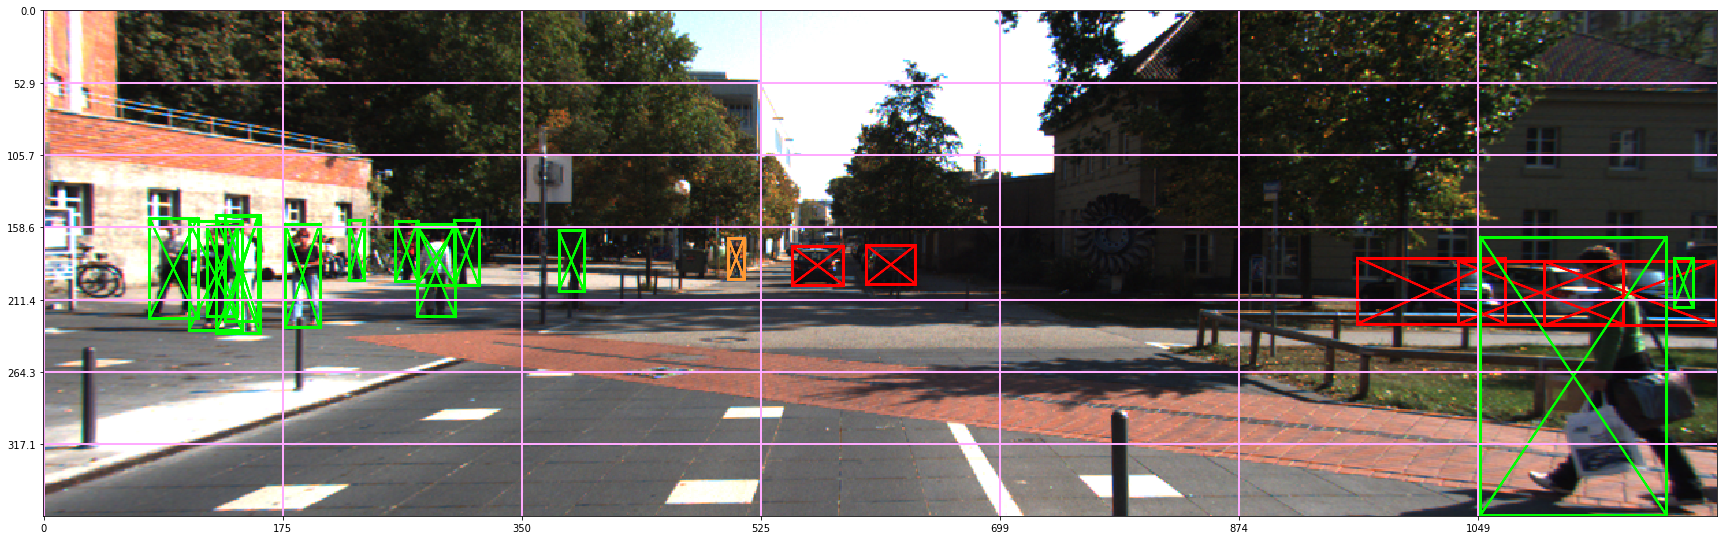

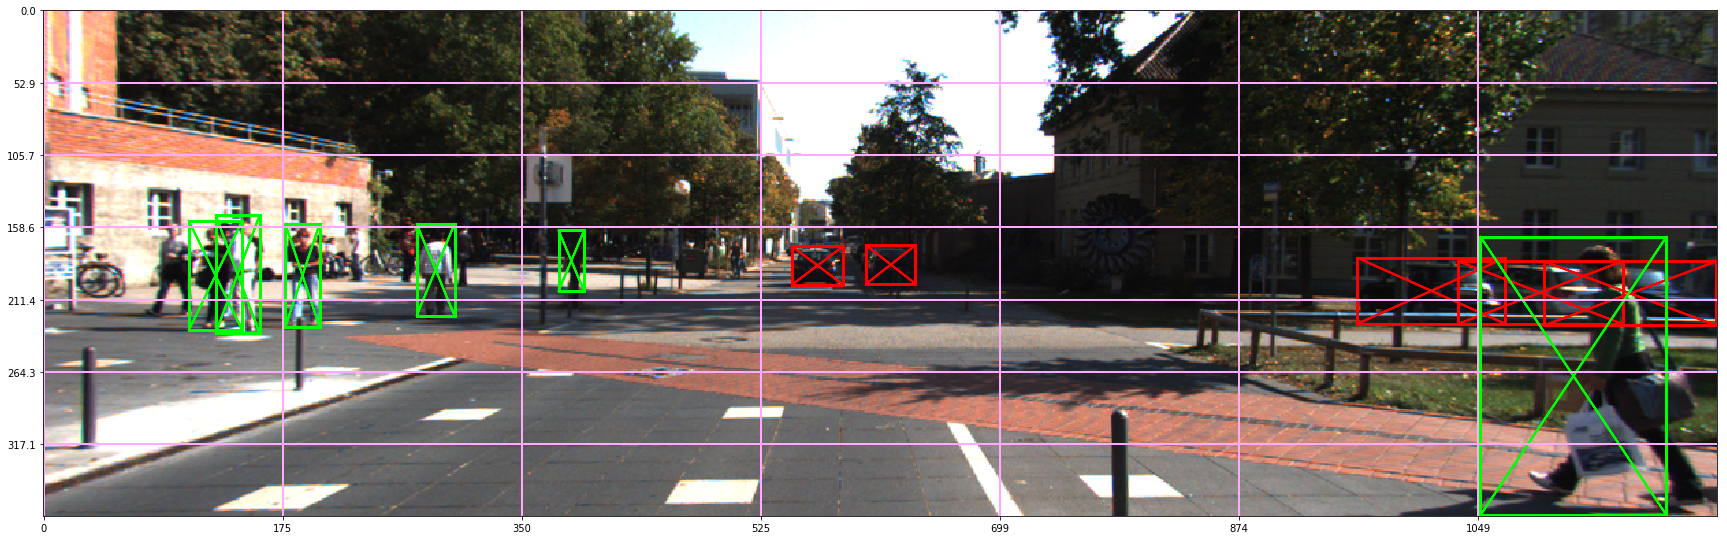

In [33]:
S = 7
image_id = 6422

# Import image
im = import_im(image_id, 'train')
im_shape = im.shape

# Import labels
original_labels = import_labels(image_id, 'train')

# Display image + labels
display_im(im, original_labels, num_cell_grid = S, display_info = False)

# Convert the labels to an array and back
arr_labels = convert_labels_to_array(original_labels, S, B, im_shape)
new_labels = convert_array_to_labels(arr_labels, S, B, im_shape)

# Display image + new_labels
display_im(im, new_labels, num_cell_grid = S, display_info = False)

## Loss Function
![The YOLO Loss Function](doc_img/YOLO_loss_function.png)